# Wie Maschinen Sprache lernen: Ein Sprachmodell trainieren.

Hier trainieren wir ein sog. *Sprachmodell*, also ein künstliches Modell natürlicher Sprache. Dazu "füttern" wir einen darauf spezialisierten Algorithmus mit einer riesigen Menge an Sprachbeispielen. Als Sprachbeispiele verwenden wir einen Datensatz von [Wortschatz Leipzig](https://wortschatz.uni-leipzig.de/de) mit 100.000 Sätzen aus deutschsprachigen Zeitungsartikeln aus dem Jahr 2022.

Grob formuliert, schaut sich der Algorithmus die Beispiele immer und immer wieder an und analysiert, wie und wo die einzelnen Wörter darin auftreten. Über die große Anzahl an Beispielen hinweg, findet der Algorithmus so Beziehungen zwischen den Wörtern sowie typische Muster, innerhalb derer sie auftreten (z.B. das vor "bin" typischerweise "ich" steht). Dadurch lernt der Algorithmus im Idealfall annäherungsweise die Bedeutung, die die Wörter für unser menschliches Sprachverständnis haben.

Wir arbeiten hier mit der Programmiersprache Python. Sämtlicher Code ist bereits fertig geschrieben und wartet nur auf Deine Ausführung. Kommentare – alles was hinter einem `#` in einer Code-Zelle steht – erläutern Dir den Code. Wenn es unklar bleibt, frag Yannick oder Josi, Deine Nachbarin oder warum nicht chatGPT?

Als Erstes importieren wir ein paar Module, die wir zum Training benötigen. Führe die folgende Code-Zelle aus, indem Du in sie reinklickst und anschließend `Shift + Enter` drückt. Diesen Befehl sollst Du ab sofort bei jeder Code-Zelle ausführen.

In [9]:
import gensim
import pandas as pd
import logging
import warnings
from tqdm import tqdm
import nltk
nltk.download('punkt')
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

[nltk_data] Downloading package punkt to /Users/Yannick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Daten einlesen

Nun wollen wir unseren Datensatz mit den 100.000 Sätzen einlesen. Zunächst laden wir ihn in der nächsten Code-Zelle von einem öffentlichen Cloud-Speicher herunter. Führe die Zelle wiederum mittels `Shift + Enter` aus.

In [20]:
!gdown 161PShTbv91QNajJdEC-UPUQQ2I_LnfYA #Download der Trainingsdaten von einer öffentlichen Google Drive

Downloading...
From: https://drive.google.com/uc?id=161PShTbv91QNajJdEC-UPUQQ2I_LnfYA
To: /Users/Yannick/Documents/Repositories/exdimed-admin/5_Bonusmaterial/data_100K.txt
100%|██████████████████████████████████████| 11.6M/11.6M [00:00<00:00, 37.6MB/s]


Im Dateimanager in der linken Seitenleiste sollte sich nun die Datei "data_100K.txt" befinden. Wenn Du sie per Doppelklick öffnest, siehst Du, dass es sich um eine Art Tabelle handelt, mit je einer Zahl sowie einem vollständigen Satz pro Zeile:

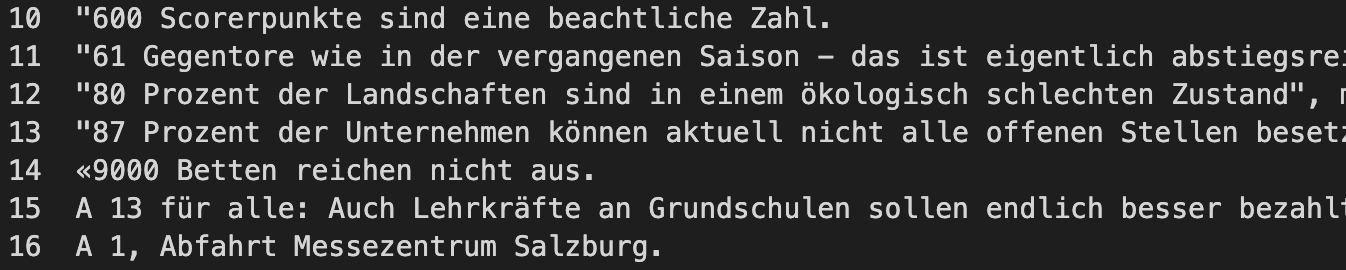

In der folgenden Code-Zelle lesen wir die Datei in den Arbeitsspeicher ein. Wir erstellen eine Liste mit Sätzen und ignorieren die Zahl am Anfang jeder Zeile.

In [3]:
#Öffnen der Datei
with open("data_100K.txt", encoding="utf-8") as read_file:

    sentences = [] #Erstellen einer leeren Liste, an die unten Satz für Satz angehängt wird

    #Iterieren über die geöffnete Datei, d.h. "Aufrufen" einer Zeile nach der anderen
    for line in read_file:

        words = line.split() #Trennen der Zeile bei jedem Leerzeichen, d.h. Erstllen einer Liste mit Wörtern
        sentence = " ".join(words[1:]) #Wiederzusammenfügen sämtlicher Wörter bis auf das erste, das ja der Zahl entspricht, die nicht zum Satz gehört
        sentences.append(sentence) #Anhängen des Satzes ohne Zeilennummer an die Liste 'sentences'

Inspizieren wir mal die eingelesenen Daten und lassen uns einen Satz ausgeben, zum Beispiel denjenigen an der Position 11 auf der Liste:

In [4]:
#Wer es genau wissen will: Beim Programmieren beginnt man bei Null zu zählen,
#deshalb handelt es sich für unser Sprachverständnis eigentlich um den zwölften Satz
sentences[11]

'"80 Prozent der Landschaften sind in einem ökologisch schlechten Zustand", mahnt Wolfgang Lucht, Professor am Potsdam-Institut für Klimafolgenforschung.'

Das sieht schon mal sehr gut aus!

Allerdings sehen wir, dass die Wörter diverse Zeichen enthalten, die wir beim Training nicht gebrauchen können. Das Anführungzeichen hinter 'Zustand"' etwa hilft dem Algorithmus nicht, sich der Bedeutung von "Zustand" anzunähern. Ebenso unnötig ist der "." am Ende von "Klimafolgenforschung.". Wir müssen unsere Daten also bereinigen. Diesen Schritt nennt man *Preprocessing*.

## 2. Daten bereinigen (Preprocessing)

Für das Preprocessing bemühen wir fertigen Code aus dem sog. *Natural Language Toolkit* (kurz: *NLTK*). Zunächst tokenisieren wir sämtliche Sätze, d.h. wir unterteilen jeden Satz auf der Liste `sentences` in eine Liste mit Wörtern. Spezialzeichen wie Anführungszeichen oder Interpunktion werden dabei als eigenständige "Wörter" gewertet. Diesen Umstand machen wir uns anschließend zunutze und entfernen sämtliche Wörter in der Satzliste, die nicht ausschließlich aus alphanumerischen Zeichen bestehen (also aus Buchstaben und/oder Zahlen).


In [5]:
preprocessed_sentences = [] #Erstellen einer leeren Liste, an die unten nach und nach die bereingiten Sätze angehängt werden

#Iterieren über die Sätze (tqdm sorgt für eine Fortschrittsanzeige während der Iteration)
for sentence in tqdm(sentences):

    words = nltk.word_tokenize(sentence, "german") #Tokenisieren des jeweiligen Satzes
    special_signs_removed = [] #Erstellen einer leeren Liste, an die unten jeweils nur die alphanumerischen Wörter angehängt werden

    #Iterieren über die Wörter im jeweiligen Satz
    for word in words:
      #Überprüfen, ob das jeweilige Wort NUR aus alphanumerischen Zeichen besteht, und wenn ja, ...
      if word.isalnum():
        special_signs_removed.append(word) #...Anhängen des Wortes an 'special_signs_removed' (wenn nein, wird das Wort übersprungen)

    preprocessed_sentences.append(special_signs_removed) #Anhängen des bereinigten, tokenisierten Satzes an 'preprocessed_sentences'

100%|█████████████| 100000/100000 [00:10<00:00, 9973.21it/s]


Nun haben wir mit `preprocessed_sentences` eine Liste mit Sätzen, wobei jeder Satz wiederum als Liste von Wörtern gespeichert ist. Das ist auch das Format, das der Algorithmus, den wir zum Trainieren unseres Sprachmodells verwenden, nämlich [*word2vec*](https://en.wikipedia.org/wiki/Word2vec), verlangt.

Schauen wir uns nochmal denselben Satz wie oben an:

In [6]:
preprocessed_sentences[11]

['80',
 'Prozent',
 'der',
 'Landschaften',
 'sind',
 'in',
 'einem',
 'ökologisch',
 'schlechten',
 'Zustand',
 'mahnt',
 'Wolfgang',
 'Lucht',
 'Professor',
 'am',
 'für',
 'Klimafolgenforschung']

Sieht doch super aus, nicht wahr?

## 3. Training

Während die Bedeutung von Wörtern bei Menschen im Sprachzentrum des Gehirns abgespeichert ist, so werden Wortbedeutungen bei word2vec in Form von Vektoren repräsentiert, also grob formuliert als Zahlenreihen, z.B. so:

    [0.9823969, -0.16720027,  0.69778556, -0.10027876,  0.70647484,  1.0204794, ...].

### 3.1. Was ist ein Vektor?

Ein Vektor besteht aus einer bestimmten Anzahl an Zahlen, wobei jede Zahl angibt, inwiefern ein bestimmtes *Feature* bei einem gegebenen Wort zutrifft. Vereinfacht kann man sich einen Vektor als eine Art Reihe an numerischen Antworten auf sinnvolle Fragen vorstellen. Die erste Zahl im Vektor (das erste Feature) stünde z.B. immer für die Anzahl an Buchstaben in einem gegebenen Wort, die zweite Zahl für die Auftretenshäufigkeit im Satz, etc. Ein komplexer Algorithmus wie word2vec kodiert allerdings keine für Menschen sinnvollen Features (Frage-Antwort-Paare), sondern die abstrakten Beziehungen und Muster zwischen Wörtern, die er beim Training entdeckt. Bei genügend Daten kann ein Modell so durchaus semantisch-syntaktisch sinnvolle Repräsentationen von Wörtern erlernen. Insgesamt entsteht beim Training ein Vektorraum, in dem die einzelnen Wortvektoren eingebettet sind, weswegen wir auch von *Word Embeddings* sprechen.

### 3.2. Wie funktioniert das Training?

Grundsätzlich unterscheidet man beim Training eines Modells zwischen überwachtem und unüberwachtem Lernen (*supervised* vs. *unsupervised learning*). Bei überwachtem Lernen wird ein Algorithmus mit annotierten Daten gefüttert, z.B. Bildern von Katzen und anderen Tieren, wobei jedes Bild mit dem Label "Katze" oder "Nicht-Katze" versehen ist. Ein Katzendetektor-Algorithmus hat beim Training Zugang zur "Wahrheit", also zur korrekten Antwort ("Katze" oder "Nicht-Katze"). Ziel des Trainings ist es, dass der Algorithmus über die Trainingsdaten hinaus zu *generalisieren* lernt, d.h. dass er nach dem Training auch unannotierten Input korrekt als Katze oder Nicht-Katze bestimmen kann.

Unüberwachtes Lernen hingegen benötigt keinerlei menschlichen Input, abgesehen von unannotierten Trainingsdaten. Word2vec ist ein unüberwachter Algorithmus. Fürs Training schafft sich word2vec ganz einfach seine eigenen Trainingsdaten: Basierend auf den vorangehenden und folgenden Wörtern innerhalb eines Satzes versucht word2vec ein verdecktes Wort in der Mitte vorherzusagen: Bei "Der schwarze Hund _____ laut" wäre "bellt" z.B. eine gute Vorhersage.

**Die Idee hinter word2vec und Word Embeddings im Allgemeinen ist nun, dass der Algorithmus für ähnliche Wörter ähnliche Vektoren erlernt, denn ähnliche Wörter kommen in ähnlichen Kontexten (mit ähnlichen vorangehenden und folgenden Wörter) vor.**

"knurrt", das ebenfalls ein guter Lückenfüller wäre, sollte demnach einen ähnlichen Vektor wie "bellt" haben. Die Ähnlichkeit von Wörtern gemäß unseres Sprachmodells schauen wir uns unten im Detail an. Zuerst müssen wir das Modell nun aber trainieren.

Wir legen dazu ein paar Parameter fest, u.a.:

- `vector_size`, das die Anzahl an Features pro Vektor festlegt.
- `window` das festlegt, wie viele Wörter vor bzw. nach dem verdeckten Wort als Kontext beim Training berücksichtigt werden sollen.
- `min_count`, das festlegt, wie oft ein Wort im Datensatz mindestens vorkommen muss, um beim Training berücksichtigt zu werden.
- `epochs`, das festlegt, wie oft der Algorithmus den ganzen Datensatz analysieren soll.

Und los geht's! Das Training nimmt einige Zeit in Anspruch. Es ist fertig, sobald links neben der Code-Zelle ein grünes Häkchen erscheint.

In [10]:
model_100K = gensim.models.Word2Vec(preprocessed_sentences, vector_size=200, window=6, min_count=3) #Definieren der "Modellarchitektur" und der Parameter
model_100K.train(sentences, total_examples=len(sentences), epochs=10) #Trainieren des Modells
model_100K = model_100K.wv #Referenzieren der Wortvektoren ("wv) des Modells, da wir fortan nur damit arbeiten werden

2023-10-23 17:40:25,715 : INFO : collecting all words and their counts
2023-10-23 17:40:25,717 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-23 17:40:25,751 : INFO : PROGRESS: at sentence #10000, processed 153126 words, keeping 29997 word types
2023-10-23 17:40:25,776 : INFO : PROGRESS: at sentence #20000, processed 299091 words, keeping 47325 word types
2023-10-23 17:40:25,809 : INFO : PROGRESS: at sentence #30000, processed 450262 words, keeping 61593 word types
2023-10-23 17:40:25,836 : INFO : PROGRESS: at sentence #40000, processed 597063 words, keeping 74030 word types
2023-10-23 17:40:25,862 : INFO : PROGRESS: at sentence #50000, processed 742751 words, keeping 84742 word types
2023-10-23 17:40:25,890 : INFO : PROGRESS: at sentence #60000, processed 891179 words, keeping 95542 word types
2023-10-23 17:40:25,919 : INFO : PROGRESS: at sentence #70000, processed 1042859 words, keeping 105886 word types
2023-10-23 17:40:25,948 : INFO : PROGRESS: a

(Sollte das Training nicht klappen oder mehr als fünf Minuten in Anspruch nehmen, kannst Du alternativ ein bereits mit denselben Daten trainiertes Modell in den Arbeitsspeicher laden. Entferne dazu die Hashtags vor dem Code in der nächsten Zelle und führe sie aus)

In [ ]:
#!gdown 1WkjMmaxQP-iL9lbiTqD9qLVpU5sOvli9
#model_100K = gensim.models.KeyedVectors.load("word2vec_100K.wordvectors", mmap='r')

Nun ist das Modell fertig trainiert.

Schauen wir uns mal den Vektor des Worts "Universität" an.

In [49]:
search_term = "Universität" #Definieren eines Suchbegriffs (Wörter bzw. bei Python sog. "Strings" stehen immer zwischen Anführungszeichen)
model_100K[search_term] #Abfragen des Vektors des jeweiligen Suchbegriffs

array([ 8.11003894e-02, -1.67931959e-01,  2.45519966e-01,  2.32791603e-01,
        3.14796925e-01,  6.81253597e-02,  6.30303323e-02,  3.89888495e-01,
        1.64728407e-02,  2.52895296e-01, -1.19539844e-02, -1.15498938e-01,
       -2.07725048e-01,  2.84083843e-01,  1.01245306e-01, -2.54587173e-01,
        1.35829270e-01,  3.97452377e-02,  1.25737697e-01, -1.98634133e-01,
        4.00902420e-01, -2.96937078e-01,  2.84571558e-01,  2.04026654e-01,
        9.72904339e-02, -1.37674376e-01,  3.55427936e-02, -1.38157979e-01,
       -4.94689971e-01,  1.84834301e-02,  2.44352043e-01, -2.53122270e-01,
        8.57460722e-02, -1.47288650e-01, -8.27192217e-02, -1.39942737e-02,
        1.79919526e-02, -3.02567333e-01, -1.15296490e-01, -3.63034397e-01,
       -8.16444457e-02, -1.56741604e-01,  1.35823682e-01,  1.01236716e-01,
        3.60807598e-01, -9.20988619e-02, -1.51762649e-01,  4.39313166e-02,
        2.36289576e-01,  2.92975187e-01, -1.26255825e-01, -5.95987402e-02,
       -1.26967713e-01,  

Spiel gerne mit anderen Wörter herum, indem Du sie bei `search_term` zwischen den Anführungszeichen einsetzt. Bei Wörtern, die das Modell nicht kennt (weil sie nicht (genügend oft) in unseren Daten vorkamen) erhältst Du einen `KeyError`.

## 4. Das Modell

Insgesamt sind diese Vektoren komplett nichtssagend für unser Sprachverständnis. Schauen wir aber, ob das Modell dennoch die Semantik von "Universität" auf seine eigene, vektorielle Weise einfangen konnte.

### 4.1. Ähnlichkeiten

Dies können wir etwa tun, in dem wir uns das ähnlichste Wort im Sprachmodell ausgeben lassen, also dasjenige Wort mit dem ähnlichsten Vektor:

In [37]:
search_term = "Universität" #Definieren eines Suchbegriffs

#Abfragen der zehn Wörter mit den ähnlichsten Vektoren zum Vektor des Suchbegriffs und Überführen in eine Tabelle (ein sog. DataFrame)
most_similar = pd.DataFrame(model_100K.most_similar(search_term, topn=10), columns=["Word", "Similarity"], index=range(1,11))
most_similar.head(1) #Ausgabe des obersten Elements der Tabelle, also des ähnlichsten Worts inkl. Ähnlichkeitsmaß

,Word,Similarity
1,Hochschule,0.966054


Vermutlich kommt "Hochschule" als ähnlichstes Wort heraus. Faszinierend, oder? Setze gerne weitere Wörter bei `search_term` zwischen den Anführungszeichen ein!

⚠️ Achtung: Hier steht "vermutlich", da jedes Modell unterschiedlich ist, auch wenn die Trainingsdaten identisch waren. Dies liegt daran, dass unser Algorithmus nicht *deterministisch* ist. Ganz am Anfang des Trainings werden den Features der Vektoren nämlich zufällige Werte zugewiesen. Das Training des Algorithmus besteht dann darin, die Features von Runde zu Runde anzupassen, um bessere Vorhersagen zu erzielen (also das verdeckte Wort besser zu erraten).

Schauen wir uns die nächstähnlichen Wörter zu "Universität" ebenfalls an:

In [45]:
most_similar #Ausgabe der gesamten Tabelle

,Word,Similarity
1,Hochschule,0.966054
2,Bahnstrecke,0.943647
3,Düsseldorf,0.942191
4,katholischen,0.941929
5,Sowjetunion,0.941695
6,Diakonie,0.941115
7,Schweizer,0.940762
8,Kanzlei,0.939648
9,Böhmischen,0.938384
10,Genf,0.937390


Spätestens hier sollten sich Unterschiede zwischen verschiedenen Modellen zeigen. Vermutlich sind auch nicht mehr alle Wörter für unser menschliches Sprachgefühl ähnlich zu "Universität".

Wir könnten nun mit den Parametern oben experimentieren (z.B. mehr Epochen oder ein größeres/kleineres Kontextfenster), um bessere Resultate zu erzielen. Zielführender ist es jedoch, das Modell mit einem größeren Datensatz zu füttern. Die Quantität an Trainingsdaten ist absolut entscheidend für ein gutes Sprachmodell, wobei die Qualität der Trainingsdaten (d.h. z.B., ob sie ausgewogen und repräsentativ sind) auch nicht außer Acht gelassen werden sollte!

Da wir an der Qualität kurzfristig nichts ändern können, verzehnfachen wir einfach mal die Quantität. Das Training mit 1 Million Sätze aus dem Wortschatz Leipzig würde relativ lange dauern, weswegen wir ganz einfach ein bereits mit 1 Million Sätzen trainiertes Model aus dem Cloud-Speicher in den Arbeitsspeicher laden:

In [21]:
#Download des mit 1 Mio. Sätzen trainierten Modells von einer öffentlichen Google Drive
!gdown 1yfvkFTUyr4tuBbGnDST9l8bDDJrKXGzG
!gdown 1ncfUD4GLkv4FBcjED5hYxwcZU9X_j32P
model_1M = gensim.models.KeyedVectors.load("word2vec_1M.wordvectors", mmap='r') #Einlesen des Modells in den Arbeitsspeicher

Downloading...
From: https://drive.google.com/uc?id=1yfvkFTUyr4tuBbGnDST9l8bDDJrKXGzG
To: /Users/Yannick/Documents/Repositories/exdimed-admin/5_Bonusmaterial/word2vec_1M.wordvectors
100%|██████████████████████████████████████| 6.05M/6.05M [00:00<00:00, 30.4MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ncfUD4GLkv4FBcjED5hYxwcZU9X_j32P
From (redirected): https://drive.google.com/uc?id=1ncfUD4GLkv4FBcjED5hYxwcZU9X_j32P&confirm=t&uuid=7a86634f-8696-4717-87c3-1245923c3367
To: /Users/Yannick/Documents/Repositories/exdimed-admin/5_Bonusmaterial/word2vec_1M.wordvectors.vectors.npy
100%|████████████████████████████████████████| 126M/126M [00:02<00:00, 57.9MB/s]


2023-10-23 18:09:02,680 : INFO : loading KeyedVectors object from word2vec_1M.wordvectors
2023-10-23 18:09:02,734 : INFO : loading vectors from word2vec_1M.wordvectors.vectors.npy with mmap=r
2023-10-23 18:09:02,744 : INFO : KeyedVectors lifecycle event {'fname': 'word2vec_1M.wordvectors', 'datetime': '2023-10-23T18:09:02.744510', 'gensim': '4.3.1', 'python': '3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'loaded'}


Schauen wir uns die zehn ähnlichsten Wörter zu "Universität" gemäß des größeren Modells an:

In [ ]:
search_term = "Universität" #Definieren eines Suchbegriffs

#Abfragen der zehn Wörter mit den ähnlichsten Vektoren zum Vektor des Suchbegriffs und Überführen in eine Tabelle (ein sog. DataFrame)
most_similar = pd.DataFrame(model_1M.most_similar(search_term, topn=10), columns=["Word", "Similarity"], index=range(1,11))
most_similar #Ausgabe der Tabelle

,Word,Similarity
1,Uni,0.892263
2,TU,0.867047
3,Hochschule,0.856717
4,Fachhochschule,0.814883
5,Akademie,0.782696
6,Künste,0.776923
7,FH,0.776245
8,Uniklinik,0.736748
9,Fakultät,0.734202
10,University,0.721199


Dies sieht schon viel besser aus!

Wenn wir nicht bloß an den ähnlichsten Wörtern zu einem bestimmten Wort interessiert sind, sondern daran, wie ähnlich bestimmte Wortpaare zueinander sind, können wir folgendermaßen vorgehen:

In [ ]:
#Schaffen einer Liste mit Wortpaaren
pairs = [
    ("Auto", "Fahrzeug"),
    ("Auto", "Fahrrad"),
    ("Auto", "Flugzeug"),
    ("Auto", "Haferflocken"),
    ("Auto", "Zahnbürste")]

#Iterieren über die Wortpaare
for w1, w2 in pairs:
    #Ausgabe der beiden Wörter sowie des Ähnlichkeitsmaßes
    print(f"{w1} und {w2:12} sind sich zu {model_1M.similarity(w1, w2)*100:.2f}% ähnlich.")

Auto und Fahrzeug     sind sich zu 89.74% ähnlich.
Auto und Fahrrad      sind sich zu 86.36% ähnlich.
Auto und Flugzeug     sind sich zu 71.34% ähnlich.
Auto und Haferflocken sind sich zu 26.29% ähnlich.
Auto und Zahnbürste   sind sich zu 10.80% ähnlich.


Auch interessant ist es, herauszufinden, welches Wort am wenigsten zu anderen gegebenen Wörtern passt:

In [48]:
the_odd_one_out = ["Berlin", "Hamburg", "Zürich", "Dresden"] #Definieren einer Liste mit (nicht) ähnlichen Wörtern
model_1M.doesnt_match(the_odd_one_out)

'Berlin'

Experimentiere bei sämtlichen "Ähnlichkeitsmethoden" mit eigenen Begriffen herum, um herauszufinden, wie gut sich der Algorithmus Deinem Sprachverständnis nach Wortbedeutungen aneignen konnte.